# Grouping unlabeled items using k-means clustering

### 10.1 The k-means clustering algorithm

In [1]:
import numpy as np

In [2]:
def loadDataSet(fileName):
    dataMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            curLine = line.strip().split('\t')
            fltLine = list(map(float, curLine))
            dataMat.append(fltLine)
    return dataMat

In [3]:
def distEclud(vecA, vecB):
    """
    计算欧几里得距离
    :param vecA: 向量A
    :param vecB: 向量B
    :return: 欧几里得距离
    """
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))

In [4]:
def randCent(dataSet, k):
    """
    随机选取k个质心
    :param dataSet: 数据集
    :param k: 质心个数
    :return: 随机选取的k个质心
    """
    n = np.shape(dataSet)[1] # 特征数
    centroids = np.mat(np.zeros((k, n))) # 初始化质心矩阵
    for j in range(n):
        minJ = min(dataSet[:, j]) # 该特征的最小值
        rangeJ = float(max(dataSet[:, j]) - minJ) # 该特征的范围
        centroids[:, j] = minJ + rangeJ * np.random.rand(k, 1) # 随机选取k个质心
    return centroids

In [5]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    """
    K-Means聚类算法
    :param dataSet: 数据集
    :param k: 质心个数
    :param distMeas: 距离计算方法
    :param createCent: 质心初始化方法
    :return: 聚类结果和质心
    """
    m = np.shape(dataSet)[0] # 数据集大小
    clusterAssment = np.mat(np.zeros((m, 2))) # 初始化聚类结果矩阵
    centroids = createCent(dataSet, k) # 随机选取k个质心

    clusterChanged = True # 标志变量，表示是否有变化
    while clusterChanged:
        clusterChanged = False # 重置标志变量
        for i in range(m): # 遍历每个数据点
            minDist = np.inf # 初始化最小距离为无穷大
            minIndex = -1 # 初始化最小距离索引为-1
            for j in range(k): # 遍历每个质心
                distJI = distMeas(centroids[j], dataSet[i]) # 计算距离
                if distJI < minDist: # 如果距离更小，则更新最小距离和索引
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i, 0] != minIndex: # 如果当前数据点的聚类结果与最小距离索引不同，则更新聚类结果，并设置标志变量为True
                clusterChanged = True
                clusterAssment[i, :] = minIndex, minDist ** 2

        print(centroids)
        for cent in range(k): # 更新质心位置
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]] # 获取当前聚类的数据点
            centroids[cent] = np.mean(ptsInClust, axis=0) # 更新质心位置为当前聚类数据点的均值

    return centroids, clusterAssment

In [6]:
dataMat = np.mat(loadDataSet('testSet.txt')) # 加载数据集
myCentroids, clustAssing = kMeans(dataMat, 4) # 调用K-Means算法

[[-2.60798975  3.05331985]
 [ 0.76921145 -1.65558415]
 [-4.07269163 -2.66585305]
 [-2.24554056 -3.04143194]]
[[-0.89339037  3.15850523]
 [ 2.8720021  -1.04881117]
 [-4.04883533 -2.77633633]
 [-2.38267313 -3.20383625]]
[[-0.59196673  3.13360545]
 [ 3.10012512 -1.31169504]
 [-4.04883533 -2.77633633]
 [-1.7671259  -3.2956472 ]]
[[-0.40420449  3.08176623]
 [ 3.13545143 -1.61935713]
 [-3.89646064 -2.78844243]
 [-1.46335425 -3.40428925]]
[[-0.17288957  3.07096154]
 [ 3.06500667 -2.04804633]
 [-3.74393844 -2.75935387]
 [-1.05904467 -3.687141  ]]
[[-0.02298687  2.99472915]
 [ 3.09814284 -2.43041226]
 [-3.61853111 -2.81946867]
 [-0.28093075 -3.880518  ]]


### 10.3 Bisecting k-means

In [7]:
def biKmeans(dataSet, k, distMeas=distEclud):
    """
    二分K-Means聚类算法
    :param dataSet: 数据集
    :param k: 质心个数
    :param distMeas: 距离计算方法
    :return: 聚类结果和质心
    """
    m = np.shape(dataSet)[0] # 数据集大小
    clusterAssment = np.mat(np.zeros((m, 2))) # 初始化聚类结果矩阵
    centroid0 = np.mean(dataSet, axis=0).tolist()[0] # 计算初始质心
    centList = [centroid0] # 初始化质心列表
    for j in range(m): # 遍历每个数据点
        clusterAssment[j, 1] = distMeas(np.mat(centroid0), dataSet[j]) ** 2 # 计算每个数据点到初始质心的距离

    while len(centList) < k: # 当质心数量小于k时，继续迭代
        lowestSSE = np.inf # 初始化最小平方误差为无穷大
        for i in range(len(centList)): # 遍历每个质心
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:, 0].A == i)[0], :] # 获取当前聚类的数据点
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas) # 对当前聚类进行K-Means聚类，分成两个子聚类
            sseSplit = sum(splitClustAss[:, 1]) # 计算平方误差
            sseNotSplit = sum(clusterAssment[np.nonzero(clusterAssment[:, 0].A != i)[0], 1]) # 计算不分裂的平方误差
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i # 记录最好的质心索引
                bestNewCents = centroidMat # 记录最好的新质心
                bestClustAss = splitClustAss.copy() # 记录最好的聚类结果
                lowestSSE = sseSplit + sseNotSplit # 更新最小平方误差
        # 更新聚类结果
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit
        print("the bestCentToSplit is: ", bestCentToSplit) # 打印最好的质心索引
        print("the len of bestClustAss is: ", len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0, :].tolist()[0] # 更新质心列表
        centList.append(bestNewCents[1, :].tolist()[0]) # 添加新的质心
        clusterAssment[np.nonzero(clusterAssment[:, 0].A == bestCentToSplit)[0], :] = bestClustAss # 更新聚类结果
        
    return np.mat(centList), clusterAssment # 返回质心和聚类结果
        

In [8]:
dataMat3 = np.mat(loadDataSet('testSet2.txt')) # 加载数据集
centList, myNewAssments = biKmeans(dataMat3, 3) # 调用二分K-Means算法
print(centList) # 打印质心

[[-1.84721709  0.29547003]
 [-4.68781715  4.16713828]]
[[ 0.84260204  0.412183  ]
 [-3.15869713  3.66477147]]
[[ 1.23710375  0.17480612]
 [-2.94737575  3.3263781 ]]
the bestCentToSplit is:  0
the len of bestClustAss is:  60
[[ 3.41920766 -4.01356086]
 [-0.08578944  4.3731958 ]]
[[-0.2878878  -2.71175265]
 [ 2.7620953   3.0613649 ]]
[[-0.45965615 -2.7782156 ]
 [ 2.93386365  3.12782785]]
[[-2.77745271  1.83165004]
 [-2.555485    4.62122963]]
[[-2.99313411  2.50954333]
 [-2.90993709  3.99469745]]
[[-2.7597694  2.5697174]
 [-3.1349821  4.0830388]]
[[-2.698236    2.64378055]
 [-3.25187989  4.160664  ]]
[[-2.64953833  2.7191465 ]
 [-3.39413187  4.2372255 ]]
[[-2.58990523  2.82015346]
 [-3.61124957  4.26650957]]
[[-2.56458833  2.9616746 ]
 [-4.095738    4.4204886 ]]
the bestCentToSplit is:  1
the len of bestClustAss is:  20
[[ 1.23710375  0.17480612]
 [-2.56458833  2.9616746 ]
 [-4.095738    4.4204886 ]]


### 10.4 Example: clustering points on a map

In [9]:
import math
def distSLC(vecA, vecB):
    '''
    计算球面距离
    :param vecA: 向量A
    :param vecB: 向量B
    :return: 球面距离
    '''
    a = math.sin(vecA[0,1] * math.pi / 180) * math.sin(vecB[0,1] * math.pi / 180) # 纬度
    b = math.cos(vecA[0,1] * math.pi / 180) * math.cos(vecB[0,1] * math.pi / 180) # 纬度
    c = math.cos(vecA[0,0] * math.pi / 180 - vecB[0,0] * math.pi / 180) # 经度
    return math.acos(a + b * c) * 6371.0 # 返回距离

In [15]:
import matplotlib.pyplot as plt
import matplotlib

def clusterClubs(fileName, imgName, numClust=5):
    """
    将文本文件的解析，聚类以及画图都封装在一起
    :param fileName: 数据文件名
    :param imgName: 图片文件名
    :param numClust: 质心个数
    """
    dataList = []
    with open(fileName) as fr:
        for line in fr.readlines():
            lineArr = line.split('\t') # 读取每一行数据
            dataList.append([float(lineArr[4]), float(lineArr[3])]) # 纬度和经度
            
    dataMat = np.mat(dataList) # 转换为矩阵
    myCentroids, clustAssing = biKmeans(dataMat, numClust, distMeas=distSLC) # 调用二分K-Means算法
    fig = plt.figure() # 创建图形
    rect = [0.1, 0.1, 0.8, 0.8] # 设置坐标轴范围
    scatterMakers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<'] # 定义不同的标记符号
    axprops = dict(xticks=[], yticks=[]) # 设置坐标轴属性
    ax0 = fig.add_axes(rect, label='ax0', **axprops) # 创建坐标轴
    imgP = plt.imread(imgName) # 读取图片
    ax0.imshow(imgP) # 显示图片
    ax1 = fig.add_axes(rect, label='ax1', frameon=False) # 创建坐标轴
    for i in range(numClust): # 遍历每个聚类
        ptsInCurrCluster = dataMat[np.nonzero(clustAssing[:, 0].A == i)[0], :] # 获取当前聚类的数据点
        markerStyle = scatterMakers[i % len(scatterMakers)] # 选择标记符号
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], ptsInCurrCluster[:, 1].flatten().A[0], marker=markerStyle, s=90)
        
    ax1.scatter(myCentroids[:, 0].flatten().A[0], myCentroids[:, 1].flatten().A[0], marker='x', s=300, c='black') # 绘制质心
    plt.show() # 显示图形
    

[[-122.4437505    45.40010576]
 [-122.54702839   45.38685351]]
[[-122.4568086    45.4961344 ]
 [-122.64533773   45.51357016]]
[[-122.50322869   45.50324862]
 [-122.66149437   45.51440946]]
[[-122.52363268   45.50792237]
 [-122.67273274   45.51397274]]
[[-122.54222807   45.51911044]
 [-122.68917857   45.50793286]]
[[-122.54868607   45.51882187]
 [-122.69551477   45.50729503]]
the bestCentToSplit is:  0
the len of bestClustAss is:  69
[[-122.60290098   45.4821227 ]
 [-122.5000749    45.51966191]]
[[-122.59137417   45.499009  ]
 [-122.53801404   45.52377508]]
[[-122.5894728    45.4876486 ]
 [-122.54052872   45.52505652]]
[[-122.72121603   45.52227145]
 [-122.64695152   45.62853479]]
[[-122.69093439   45.49080906]
 [-122.72070683   45.59796783]]
[[-122.69000022   45.48917759]
 [-122.72072414   45.59011757]]
the bestCentToSplit is:  1
the len of bestClustAss is:  39
[[-122.41837125   45.43066032]
 [-122.47641191   45.44533669]]
[[-122.376304     45.430319  ]
 [-122.55463028   45.52187369]]


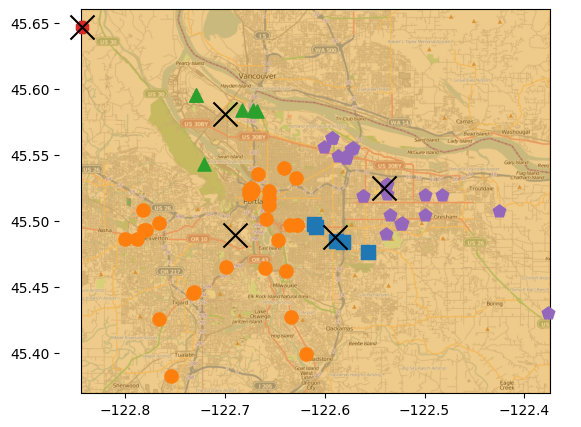

In [18]:
clusterClubs('places.txt', 'Portland.png', 5) # 调用函数，绘制聚类结果